In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

In [3]:
wr = pd.read_csv("../data/weather/weather_report_DecJan.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [4]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [5]:
wr["Time"] = wr["Date"] + wr["Hour"]

In [20]:
# wr.columns = wr.columns.str.lower()
# wr.columns = wr.columns.str.replace("%", "perc")
# wr.columns = wr.columns.str.replace("°", "degrees")
# wr.columns = wr.columns.str.replace(" ", "")
# wr.columns

#wr.columns[wr.columns.str.contains("Hly")].str.replace("Hly", "")

Text(0, 0.5, 'Humidity')

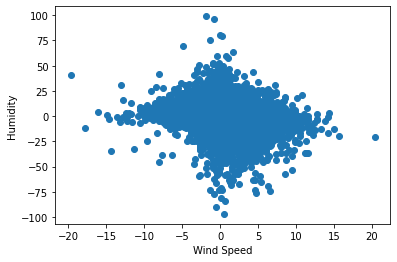

In [96]:
ax = plt.axes()
plt.scatter(wr["HlyWindSpd (MPH)"].diff().values, wr["HlyRelHum (%)"].diff().values)
ax.set_xlabel("Wind Speed")
ax.set_ylabel("Humidity")

In [134]:
wr[target_columns].apply(np.log).corr().loc["HlyWindSpd (MPH)"]

HlyAirTmp (F)         0.288108
HlyDewPnt (F)        -0.081907
HlyEto (in)           0.266073
HlyNetRad (Ly/day)    0.137092
HlyAsceEto (in)       0.251585
HlyAsceEtr (in)       0.424898
HlyPrecip (in)        0.144005
HlyRelHum (%)        -0.286766
HlyResWind (MPH)      0.897546
HlySoilTmp (F)       -0.067210
HlySolRad (Ly/day)    0.264013
HlyVapPres (mBars)   -0.074260
HlyWindDir (°)        0.054940
HlyWindSpd (MPH)      1.000000
Name: HlyWindSpd (MPH), dtype: float64

In [6]:
se_dates = source[["start", "end"]]
se_dates = se_dates[~se_dates.duplicated()].sort_values(by="start").reset_index(drop=True)
se_dates.iloc[6:]

,start,end
6,2020-12-04,2020-12-14
7,2020-12-16,2020-12-24
8,2021-01-12,2021-01-21


In [7]:
notifications = pd.read_csv("../data/2021/deenergization_2021.csv", parse_dates=True)
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)

notif_by_county = notifications.County.value_counts().sort_values()
notif_by_county = notif_by_county

counties = []
for county in notif_by_county.index:
     for c in county.split(";"):
            counties.append(c.title())

psps_county_stations = ws[ws.County.isin(counties)].StationNbr

set(counties), psps_county_stations.values

({'Fresno',
  'Kern',
  'Los Angeles',
  'Madera',
  'Orange',
  'Riverside',
  'San Bernardino',
  'San Diego',
  'Ventura'},
 array([  1,   2,   5,   7,   9,  10,  11,  24,  25,  26,  29,  31,  34,
         36,  39,  40,  44,  45,  49,  50,  54,  55,  58,  59,  60,  62,
         66,  73,  74,  75,  78,  80,  82,  93,  97,  98,  99, 101, 102,
        105, 110, 117, 118, 124, 125, 130, 133, 134, 135, 136, 137, 138,
        141, 142, 145, 146, 147, 150, 151, 152, 153, 154, 156, 159, 162,
        172, 173, 174, 176, 179, 184, 188, 190, 192, 197, 198, 199, 200,
        204, 205, 207, 208, 215, 216, 217, 218, 219, 220, 221, 223, 233,
        234, 237, 238, 239, 240, 241, 245, 251, 255, 256, 257]))

In [8]:
wind_max = wr[wr.Station.isin(psps_county_stations.values)][["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max = wind_max[(wind_max > 25) & (wind_max < 60)].dropna()
wind_max

,HlyWindSpd (MPH)
Station,
125,30.6
197,29.5
204,28.0
234,26.1


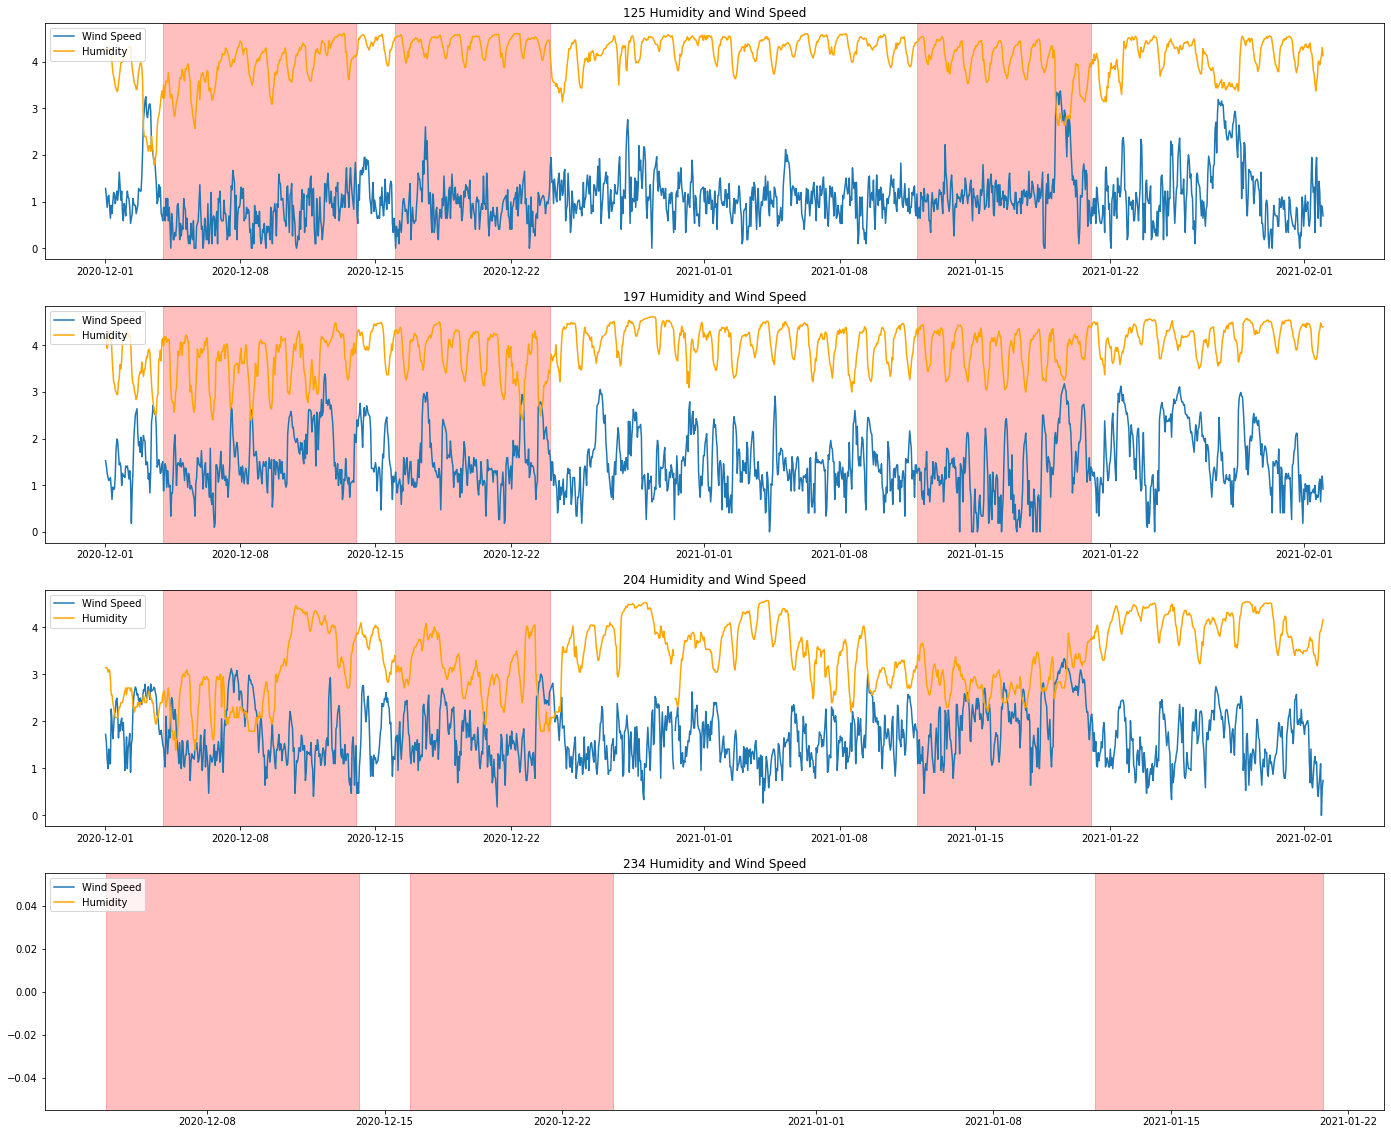

In [9]:
stations = wind_max.index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20))
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity and Wind Speed".format(s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


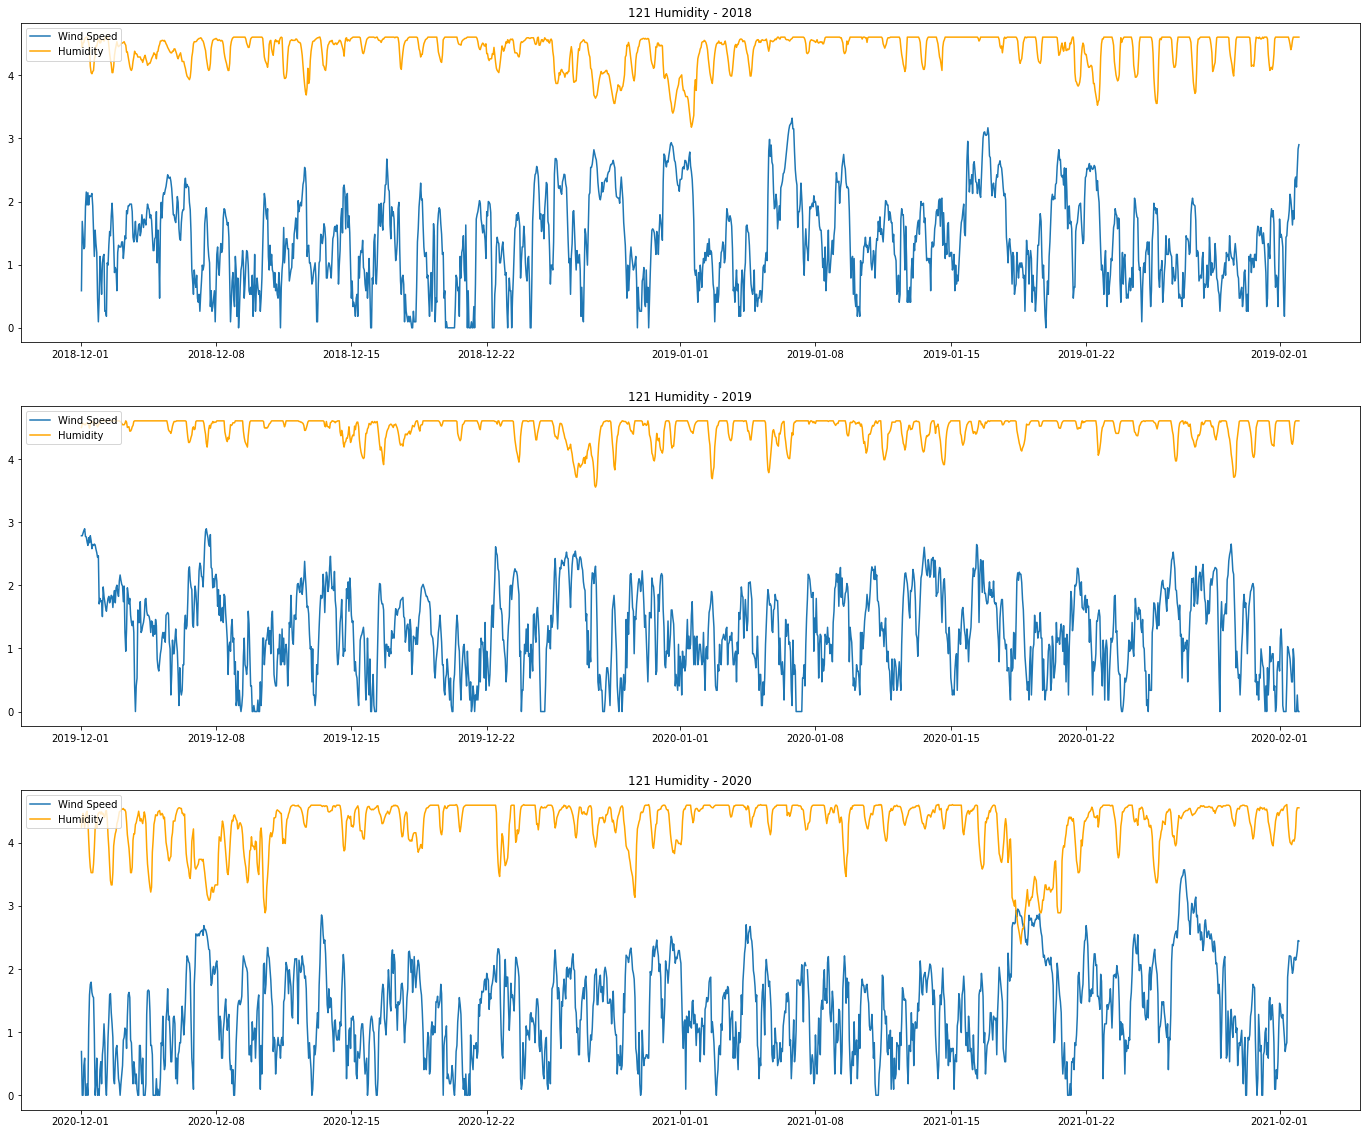

In [10]:
s = 121
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20))
for (year, v_ax) in zip(["2018", "2019", "2020"], ax): 
        start = pd.Timestamp("{}-12-01".format(year))
        end = start + two_months
    
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
        v_ax.set_title("{} Humidity - {}".format(s, year))
        
        # For multiple date ranges, highlight relevant time
#         v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

        v_ax.legend(loc="upper left")
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))


## GlutonTS

In [11]:
wr_gts = wr.copy()
wr_gts.set_index("Time", inplace=True)
# wr_gts = wr_gts[wr_gts.columns[(wr_gts.columns.str.contains("Hly")) | (wr_gts.columns.str.contains("Station"))]]

In [544]:
next(iter(wr_gts.groupby(["Station", pd.Grouper(freq='1AS-DEC')])))

((2, Timestamp('2018-12-01 00:00:00', freq='AS-DEC')),
                           Date  Julian            Hour  Station Standard  \
 Time                                                                       
 2018-12-01 01:00:00 2018-12-01     335 0 days 01:00:00        2  english   
 2018-12-01 02:00:00 2018-12-01     335 0 days 02:00:00        2  english   
 2018-12-01 03:00:00 2018-12-01     335 0 days 03:00:00        2  english   
 2018-12-01 04:00:00 2018-12-01     335 0 days 04:00:00        2  english   
 2018-12-01 05:00:00 2018-12-01     335 0 days 05:00:00        2  english   
 ...                        ...     ...             ...      ...      ...   
 2019-02-01 20:00:00 2019-02-01      32 0 days 20:00:00        2  english   
 2019-02-01 21:00:00 2019-02-01      32 0 days 21:00:00        2  english   
 2019-02-01 22:00:00 2019-02-01      32 0 days 22:00:00        2  english   
 2019-02-01 23:00:00 2019-02-01      32 0 days 23:00:00        2  english   
 2019-02-02 00:00:00 

In [12]:
from gluonts.dataset.common import ListDataset

target_columns = wr_gts.columns[wr_gts.columns.str.contains("Hly")]

training_data = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for (_, df) in wr_gts.groupby(["Station", *target_columns, pd.Grouper(freq='1AS-DEC')])],
    freq = "60min"
)

In [13]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq="60min", prediction_length=24*3, trainer=Trainer(epochs=20))

In [14]:
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


UnboundLocalError: local variable 'lv' referenced before assignment

Skipping  0 HlyAirTmp (F)
Skipping  1 HlyDewPnt (F)
Skipping  2 HlyEto (in)
Skipping  3 HlyNetRad (Ly/day)
Skipping  4 HlyAsceEto (in)
Skipping  5 HlyAsceEtr (in)
Skipping  6 HlyPrecip (in)
Skipping  7 HlyRelHum (%)
Skipping  8 HlyResWind (MPH)
Skipping  9 HlySoilTmp (F)
Skipping  10 HlySolRad (Ly/day)
Skipping  11 HlyVapPres (mBars)
Skipping  12 HlyWindDir (°)
Showing  13 HlyWindSpd (MPH)


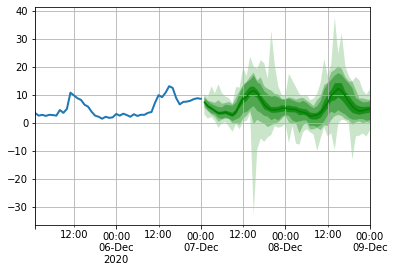

In [61]:
from gluonts.dataset.util import to_pandas
i = 0
for test_entry, forecast in zip(training_data, predictor.predict(training_data)):
    if i == len(wr_gts.columns)-1:
        print("Showing ", i, wr_gts.columns[i])
        to_pandas(test_entry)[-48:].plot(linewidth=2)
        forecast.plot(color='g', prediction_intervals=[50,90,95,99])
    else:
        print("Skipping ", i, wr_gts.columns[i])
        i+=1
plt.grid(which='both')

In [170]:
from pathlib import Path
predictor.serialize(Path("../models/"))

In [154]:
from gluonts.evaluation import make_evaluation_predictions

In [155]:
wr_test = wr[wr.Station==121]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[wr_test.columns[wr_test.columns.str.contains("Hly")]]
wr_test.head()

,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),HlyNetRad (Ly/day),HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
Time,,,,,,,,,,,,,,
2020-12-01 01:00:00,42.3,33.1,0.0,-91.0,0.0,NaN,0.0,70.0,1.7,48.8,0.0,6.4,316.0,2.0
2020-12-01 02:00:00,35.5,30.6,0.0,-89.0,0.0,NaN,0.0,82.0,0.9,48.7,0.0,5.8,249.0,1.0
2020-12-01 03:00:00,34.4,30.9,0.0,-88.0,0.0,NaN,0.0,87.0,0.9,48.6,0.0,5.9,247.0,1.0
2020-12-01 04:00:00,38.4,32.9,0.0,-89.0,0.0,NaN,0.0,81.0,1.3,48.4,0.0,6.3,337.0,1.6
2020-12-01 05:00:00,44.0,34.5,0.0,-91.0,0.0,NaN,0.0,69.0,1.6,48.3,0.0,6.8,349.0,1.8


In [163]:
test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [164]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [165]:
forecasts = list(forecast_it)
tss = list(ts_it)

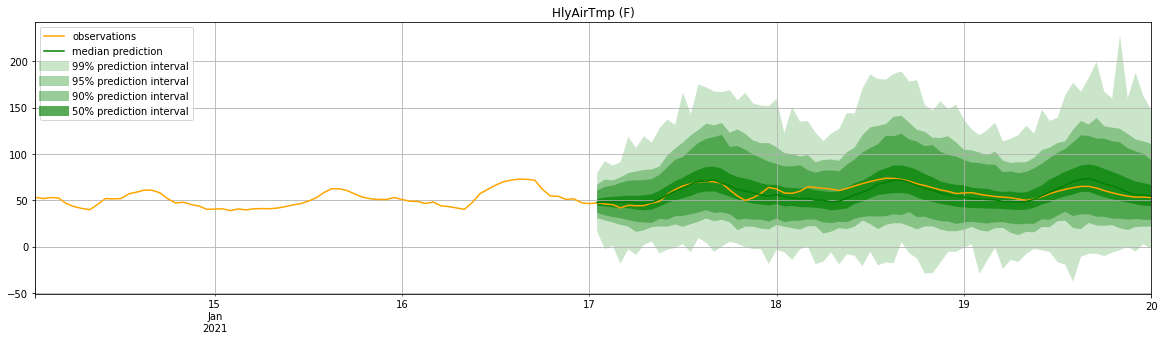

In [168]:
plot_length = 2*3*24
prediction_intervals = [50,90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

for i in [0]:
    tss[i][-plot_length:].plot(ax=ax, color="orange")  # plot the time series
    forecasts[i].plot(prediction_intervals=prediction_intervals, color='g')

#ax.set_xbound("2021-01-17", "2021-01-19")
#ax.set_ybound(0,100)
plt.title(wr_test.columns[i])
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

- Inputs
    - PSPS Report Processing, Duration of events
        - 2 months of data
        - 3 events
    - CIMIS Weather Station Data
        - 200 Weather Stations
        - 13 readings from the weather station:  wind, humidity, temp, etc.
        - Total records:  230k, 1 hour each
        -* Cross-check events and weather stations
- Outputs
    - Trained model for predicting risk
    -* How can it be used?
        - Ex. Next 5 days, low fire risk at weather stations x,y,z with prob %
- Methods
    - Document reading/table extraction for PSPS data
    - Access CIMIS API
    - Join/match data sources based on time
    - During PSPS event, extreme wind/humidity values were observed
        - Pull 2020 and 2019 data for Dec/Jan
        -* Were there any high threshold events with no PSPS?  False Negative
        -* And False Positives?  A PSPS event with no high values?
    - Built a prediction model to anticipate extreme wind/humidity
        -* Produce a statistic:  Prob of high wind in next x days
        -* Train model for next 2,3,7 days?
- Challenges/Insights
    - Data feed morning/evening.  How to handle new data?
    - Input from metereology to improve/tune models
    - Relationship between wind/humidity, wind brings humidity down, increasing fire risk
    - GluonTS quantifies risk

In [306]:
from gluonts.evaluation import Evaluator

In [331]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 14/14 [00:00<00:00, 115.51it/s]WARNING:gluonts.time_feature.seasonality:Multiple 60 does not divide base seasonality 1. Falling back to seasonality 1.

/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1516: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


In [332]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4273.5503099257685,
    "abs_error": 72759.64903575182,
    "abs_target_sum": 138090.98112299852,
    "abs_target_mean": 63.228471210164166,
    "seasonal_error": 17.917226598851734,
    "MASE": 2004.456540348366,
    "MAPE": 73.81186080021835,
    "sMAPE": 0.9104988374116221,
    "OWA": NaN,
    "MSIS": 56583.599691533236,
    "QuantileLoss[0.1]": 33560.244213016755,
    "Coverage[0.1]": 0.28479853479853473,
    "QuantileLoss[0.5]": 72759.64931534314,
    "Coverage[0.5]": 0.63003663003663,
    "QuantileLoss[0.9]": 27131.554263551552,
    "Coverage[0.9]": 0.8424908424908424,
    "QuantileLoss[0.95]": 14873.619202116366,
    "Coverage[0.95]": 0.8933150183150182,
    "QuantileLoss[0.99]": 4458.89259215909,
    "Coverage[0.99]": 0.940018315018315,
    "RMSE": 65.37239715603037,
    "NRMSE": 1.0339076037239623,
    "ND": 0.526896459450486,
    "wQuantileLoss[0.1]": 0.24302994982072312,
    "wQuantileLoss[0.5]": 0.5268964614751752,
    "wQuantileLoss[0.9]": 0.19647593233757463,